## Import Images

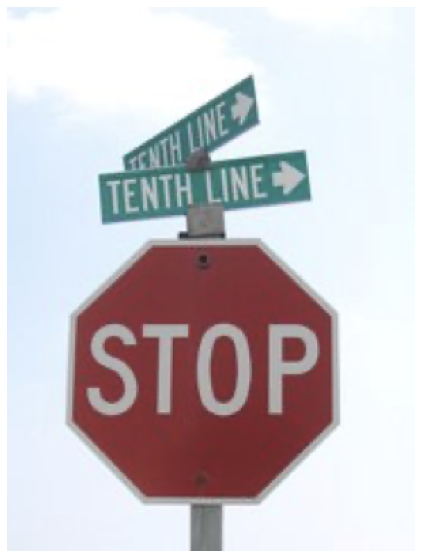

In [197]:
#!/bin/python3

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

# First 51 imgs are semaphores
def importImage(no):
    return cv.imread('dataset/images/road' + str(no) + '.png', cv.IMREAD_COLOR)

def displayImage(image, title=""):
    if (len(image.shape) == 3):
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        cmap = None
    else:
        cmap = "gray"
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

displayImage(importImage(52))

## Export XML

In [198]:
import xml.etree.ElementTree as ET

df = pd.DataFrame(columns=["type"])

for i in range(0, 877):
    with open(f"dataset/annotations/road{i}.xml") as xml:
        tree = ET.parse(xml)
        root = tree.getroot()
        
        objects = root.findall("object")
        types = []
        for object in objects:
            types.append(object.find("name").text)

        df.loc[i] = ([types])

df.to_csv("dataset/signs.csv", index=False)

## Import XML

In [199]:
signs = pd.read_csv("dataset/signs.csv")

def typeToList(x):
    x["type"] = x["type"].replace("[", "")
    x["type"] = x["type"].replace("]", "")
    x["type"] = x["type"].replace("'", "")
    x["type"] = x["type"].strip()
    x["type"] = x["type"].split(", ")
    return x["type"]

signs["type"] = signs.apply(typeToList, axis=1)

def filterType(type):
    def filter(x):
        return len(set(x["type"]) & set(type)) != 0

    #print(signs.apply(filter, axis=1))
    return signs[signs.apply(filter, axis=1) == True]

filterType(["speedlimit"])

,type
100,[speedlimit]
101,[speedlimit]
102,[speedlimit]
103,[speedlimit]
104,[speedlimit]
...,...
871,[speedlimit]
872,"[speedlimit, stop]"
873,"[speedlimit, speedlimit, stop]"
874,"[speedlimit, speedlimit, stop]"


## Segmentação em áreas de interesse
Nesta secção iremos delimitar quais as áreas em que estamos interessados em analisar. Estas regiões correspondem às que contêm os sinais. Para isso iremos usar o colorspace HSV para filtrar as cores de interesse: **azul** e **vermelho**


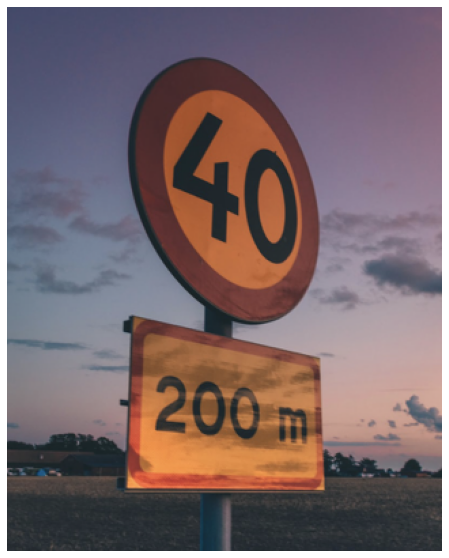

In [200]:
testImages = {"speedlimit": (7, 19, 20, 70)}
speedLimitId = filterType(["speedlimit"]).index[7]
speedLimit = importImage(speedLimitId)
#speedLimit = cv.imread('dataset/images/test.png')
displayImage(speedLimit)

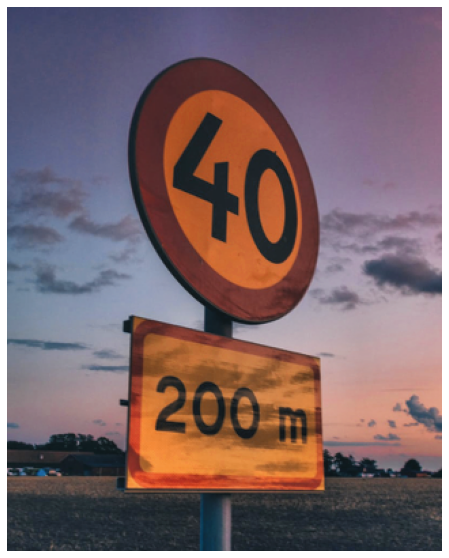

In [201]:
clahe = cv.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
hsv = cv.cvtColor(speedLimit, cv.COLOR_BGR2HSV)
h,s,v = cv.split(hsv)
s = clahe.apply(s)
v = clahe.apply(v)
img = cv.merge([h, s, v])
speedLimit = cv.cvtColor(img, cv.COLOR_HSV2BGR)
displayImage(speedLimit)

### Mean Shift
Usado para uniformizar cor da imagem

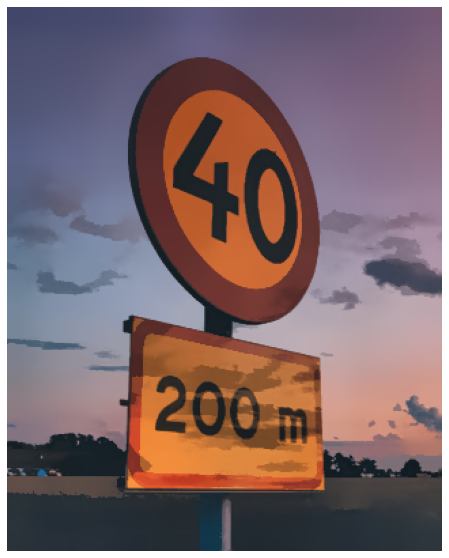

In [202]:
img = speedLimit

segmentedRoadImg = cv.pyrMeanShiftFiltering(img, 10, 25, 100)

displayImage(segmentedRoadImg)

### Filtro usando HSV
Utilizando as equações em TODO, podemos usar um threshold para selecionar apenas a regiões de forte saturação com fortes intensidades de vermelho ou azul.

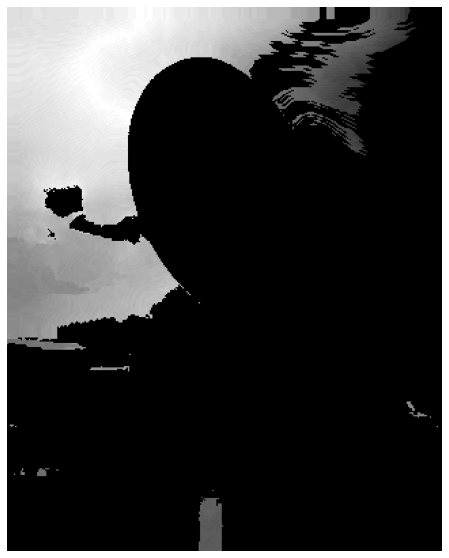

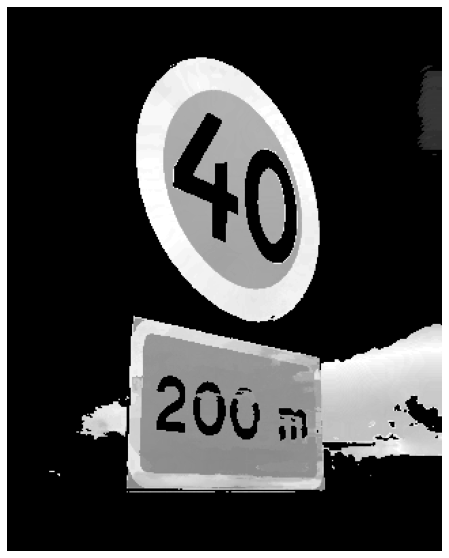

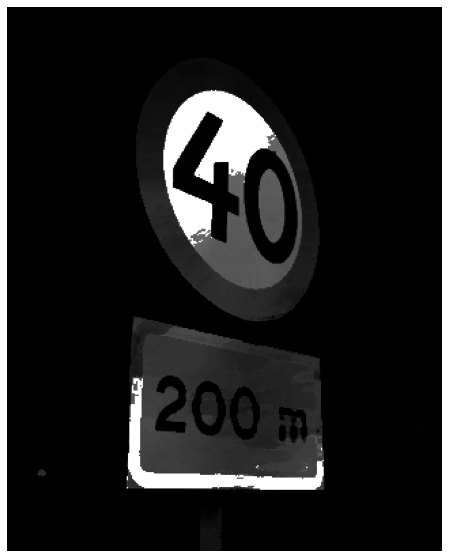

(None, None, None)

In [203]:
def splitColor(img):
    def calcScore(B, G, R, S):
        R /= 255
        G /= 255
        B /= 255
        TH1, TH2 = 0.10, 0.5
        DIFF_TH = 30 / 255
        c_max = max(R, G, B)
        c_min = min(R, G, B)

        if (c_max == B and (c_max - c_min) >= DIFF_TH):
            hd_blue = 1 - abs(R - G) / (c_max - c_min)
        else:
            hd_blue = 0

        if (c_max == R and (c_max - c_min) >= DIFF_TH):
            hd_red = 1 - abs(G - B) / (c_max - c_min)
        else:
            hd_red = 0
        from math import e
        sd = e ** -(((S - 255) ** 2) / (115 ** 2))

        hs = max(hd_blue, hd_red) * sd
        if hs < TH1:
            hs = 0
        elif TH1 <= hs < TH2:
            hs = ((hs - TH1) ** 2) / (TH2 - TH1)
        else:
            hs = 1

        return hd_blue * 255, hd_red * 255, hs * 255


    height, width = img.shape[0], img.shape[1]
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    b, g, r = cv.split(img)
    h, s, v = cv.split(hsv)
    blank_image_b = np.zeros((height, width), np.uint8)
    blank_image_r = np.zeros((height, width), np.uint8)
    blank_image_hs = np.zeros((height, width), np.uint8)

    for i in range(height):
        for j in range(width):
            b_val, r_val, hs_val = calcScore(b[i, j], g[i, j], r[i, j], s[i, j])
            blank_image_b[i, j] = b_val
            blank_image_r[i, j] = r_val
            blank_image_hs[i, j] = hs_val

    return (blank_image_b, blank_image_r, blank_image_hs)
65
b, r, hs = splitColor(segmentedRoadImg)
displayImage(b), displayImage(r), displayImage(hs)

### Bounding Boxes - Detecting ROI
Falar um pouco disto
Ainda falta meter um min size nos countours TODO

Applu Canny first

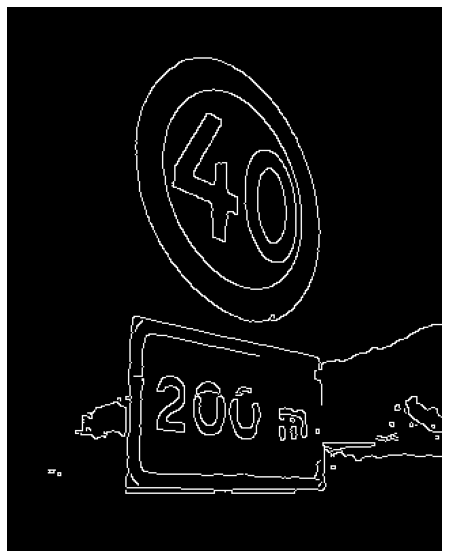

In [204]:
img = r.copy()
#img = cv.blur(img, (5, 5))
img = cv.GaussianBlur(img, (3, 3), 0)
img = cv.Canny(img, 120, 220)
#img = cv.Laplacian(img, cv.CV_16S, ksize=5)
#img = cv.convertScaleAbs(img)
displayImage(img)

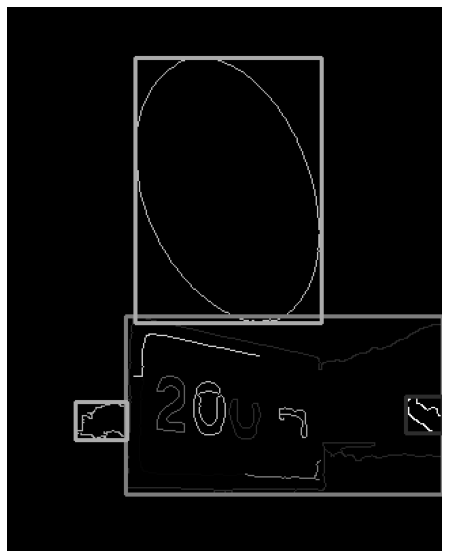

In [205]:
import random as rng

rng.seed(123)

def isInsideRects(rect, rects):
    def isInside(r1, r2):
        (r1_x1, r1_y1, r1_w, r1_h) = r1
        r1_x2, r1_y2 = r1_x1 + r1_w, r1_y1 + r1_h
        (r2_x1, r2_y1, r2_w, r2_h) = r2
        r2_x2, r2_y2 = r2_x1 + r2_w, r2_y1 + r2_h
        return r1_x1 < r2_x1 < r2_x2 < r1_x2 and r1_y1 < r2_y1 < r2_y2 < r1_y2
    for r in rects:
        if isInside(r, rect):
            return True
    return False


MIN_SIZE = 10
ret,thresh = cv.threshold(img,200,200,0)
contours,hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE) # TODO

# Get rects
tmp_rects = []
colors = []
#drawing = img.copy()
drawing = np.zeros((img.shape[0], img.shape[1], 1), np.uint8)
for i in range(len(contours)):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cnt = contours[i]
    x,y,w,h = cv.boundingRect(cnt)
    rect = (x, y, w, h)
    if (w < MIN_SIZE or h < MIN_SIZE):
        continue
    cv.drawContours(drawing, contours, i, color)
    tmp_rects.append(rect)
    colors.append(color)
    #cv.drawContours(drawing, hulls, i, color)

tmp_rects.sort(key=lambda rect: rect[2] * rect[3], reverse=True)
rects = []
for rect in tmp_rects:
    if not isInsideRects(rect, rects):
        rects.append(rect)

for i in range(len(rects)):
    x, y, w, h = rects[i]
    color = colors[i]
    cv.rectangle(drawing,(x,y),(x+w,y+h),color,2)

displayImage(drawing)

## Harris Corner Detection

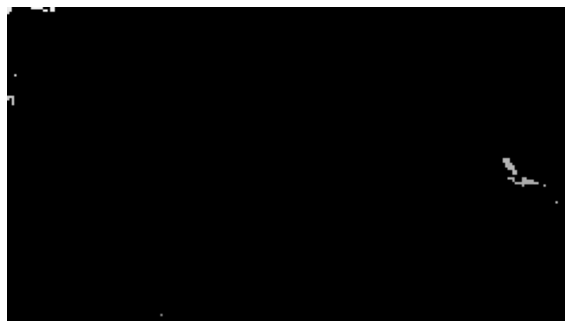

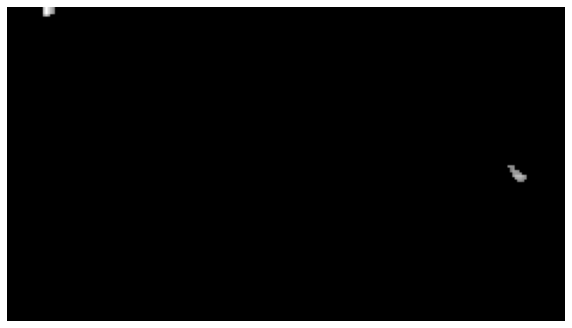

In [206]:
def addPadding(rect, img, padding):
    w, h = rect[2], rect[3]
    y1 = max(0, round(rect[1] - h * padding))
    y2 = min(img.shape[0], round(rect[1] + h + h * padding))
    x1 = max(0, round(rect[0] - w * padding))
    x2 = min(img.shape[1], round(rect[0] + w + w * padding))

    return img[y1:y2, x1:x2]
blur = cv.blur(img,(5,5))
img = b.copy()
roi = addPadding(rects[0], img, 0)

neighbourhood = 9
aperture = 3
free_param = 0.04
harris = cv.cornerHarris(roi, neighbourhood, aperture, free_param)
threshold = 0.50

harris[harris < threshold * harris.max()] = 0
displayImage(roi)
displayImage(harris)

### Corner Detection - Triangle and square identification

In [207]:
def cornerIdentification(img):
    img = img.copy()
    width, height = img.shape[0], img.shape[1]
    # Identify areas of interest inside the roi
    ratio = 1 / 8
    x_tick = round(img.shape[0] * ratio)
    y_tick = round(img.shape[1] * ratio)
    tl_range = slice(0, 2 * y_tick + 1), slice(0, 2 * x_tick + 1)
    tr_range = slice(0, 2 * y_tick + 1), slice(6 * x_tick, img.shape[1] + 1)
    bl_range = slice(6 * y_tick, img.shape[1] + 1), slice(0, 2 * x_tick + 1)
    br_range = slice(6 * y_tick, img.shape[1] + 1), slice(6 * x_tick, img.shape[1] + 1)

    tc_range = slice(0, 2 * y_tick + 1), slice(3 * x_tick, 5 * x_tick + 1)
    bc_range = slice(6 * y_tick, img.shape[1] + 1), slice(3 * x_tick, 5 * x_tick + 1)

    # Assign values if corners are found inside them
    tl, tr, bl, br = 0, 0, 0, 0
    if np.any(img[tl_range]): tl = 0.25
    if np.any(img[tr_range]): tr = 0.25
    if np.any(img[bl_range]): bl = 0.25
    if np.any(img[br_range]): br = 0.25

    tc, bc = 0, 0
    if np.any(img[tc_range]): tc = 0.34
    if np.any(img[bc_range]): bc = 0.34

    square = tl + tr + bl + br
    triangle_up = 1.32 * (bl + br) + tc - 1.1 * (tl + tr)
    triangle_down = 1.32 * (tl + tr) + bc - 1.1 * (bl + br)

    # print(square, triangle_up, triangle_down)
    return square, triangle_up, triangle_down

    
cornerIdentification(harris)

(0.25, -0.275, 0.33)

### Circle Detection

In [208]:
MIN_RADIUS = 30
def circleIdentification(img):
    import frs
    img = img.copy()

    frs_res = frs.frst(img, img.shape[0]//2, 2, 0, img.shape[0]/4, "BRIGHT")
    w, h = frs_res.shape[0], frs_res.shape[1]
    dim = max(w, h)
    tick = 1 / 5
    region = slice(round(2 * tick * dim), round(3 * tick * dim)), slice(round(2 * tick * dim), round(3 * tick * dim))

    m = frs_res[region].max()
    avg = np.average(frs_res[region])
    # print("M: ", m, "AVG: ", avg, avg / m)
    # print(frs_res[region])
    #displayImage(frs_res[region])
    #displayImage(frs_res)
    cp = avg / m
    return cp


circleIdentification(roi)


0.04047786146290918

## Shape detection

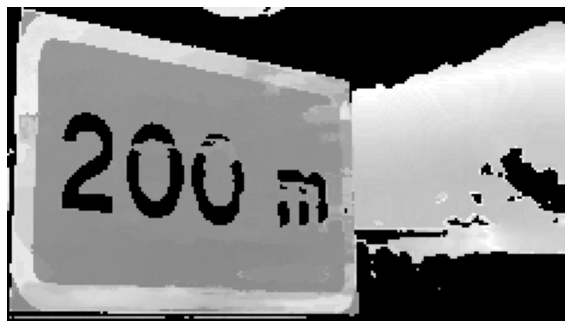

Red - Square:  0.5  TriUp:  -0.21000000000000002  TriDown:  0.66  Circle:  0.262606216412087


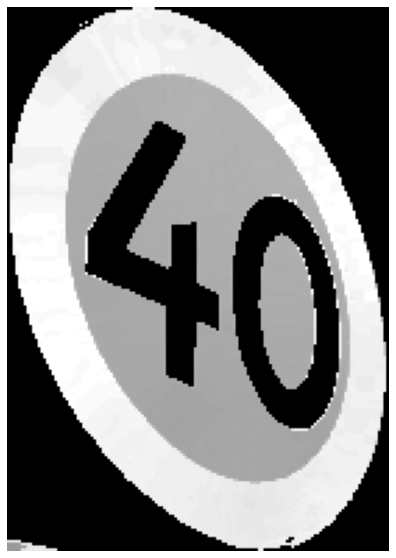

Red - Square:  0.5  TriUp:  0.395  TriDown:  0.395  Circle:  0.5302451913936469


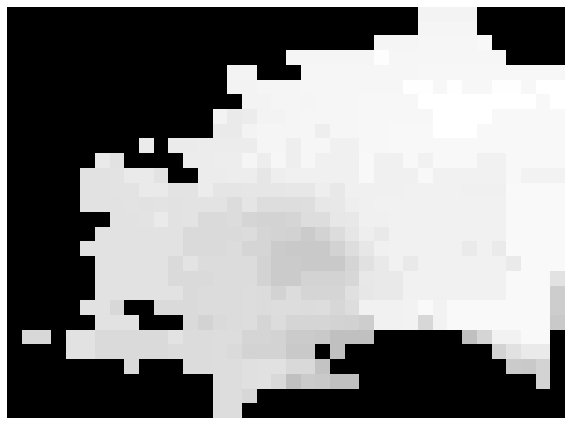

Red - Square:  0.5  TriUp:  -0.21000000000000002  TriDown:  0.66  Circle:  0.34684823618315946


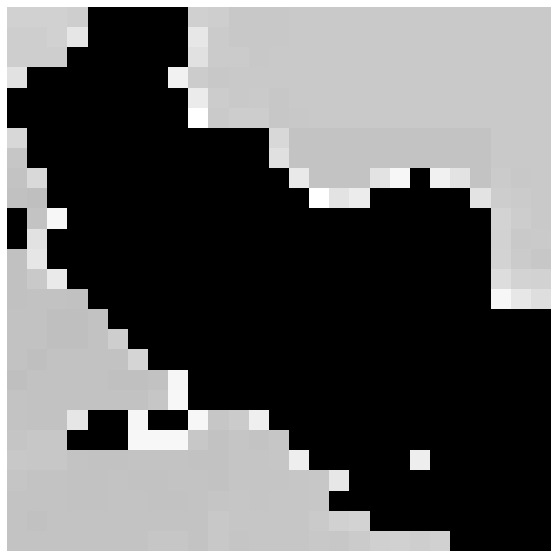

Red - Square:  1.0  TriUp:  0.44999999999999996  TriDown:  0.44999999999999996  Circle:  0.36874285881942487


['yield', 'prohibition', 'yield', 'stop']

In [209]:
COLOR_THRESHOLD = 0.5
SHAPE_THRESHOLD = 0.4

# from enum import Enum
# class Sign(Enum):
#     STOP = 1
#     INFORMATION = 2
#     SPEEDLIMIT = 3
#     WARNING = 4
#     PRIORITY = 5

def get_signs(b, r, rects):

    def sign(b, r, rect):
        blue = addPadding(rect, b, 0)
        red = addPadding(rect, r, 0)

        blue_ratio = np.count_nonzero(blue) / len(blue)
        red_ratio = np.count_nonzero(red) / len(red)
        max_ratio = max(blue_ratio, red_ratio)

        if max_ratio < COLOR_THRESHOLD:
            return "trash"

        if blue_ratio == max_ratio: # Is Blue
            sq, t_up, t_down = cornerIdentification(blue)
            circle = circleIdentification(blue)
            shape_max = max(sq, t_up, t_down, circle)
            displayImage(blue)
            print("Blue - Square: ", sq, " TriUp: ", t_up, " TriDown: ", t_down, " Circle: ", circle)
            if shape_max < SHAPE_THRESHOLD:
                return "trash"

            if sq == shape_max:
                return "information"
            if circle == shape_max:
                return "obligation"
            return "trash" # Is Blue Triangle, Wtf?
        elif red_ratio == max_ratio: # Is Red
            sq, t_up, t_down = cornerIdentification(red)
            circle = circleIdentification(red)
            shape_max = max(sq, t_up, t_down, circle)
            displayImage(red)
            print("Red - Square: ", sq, " TriUp: ", t_up, " TriDown: ", t_down, " Circle: ", circle)
            if shape_max < SHAPE_THRESHOLD:
                return "trash"

            if t_up == shape_max:
                return "danger"
            if t_down == shape_max:
                return "yield"
            if circle == shape_max:
                return "prohibition"
            return "stop" # Is Red Square => Wtf?

        return "trash"

    ret = []
    for rect in rects:
        ret.append(sign(b, r, rect))
    return ret

get_signs(b, r, rects)

